Extension 2: Create some additional test data for the greek letter task. Please include the examples as a zip file in your submission.
Haotian Shen, Qiaozhi Liu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
%matplotlib inline

In [3]:
torch.cuda.is_available()

False

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale(x)
        x = torchvision.transforms.functional.affine(x, 0, (0, 0), 1 / 120, 0)
        x = torchvision.transforms.functional.center_crop(x, (28, 28))
        return torchvision.transforms.functional.invert(x)

In [6]:
    n_epochs = 10
    learning_rate = 0.5
    batch_size_train = 5
    batch_size_test = 9
    momentum = 0.5
    log_interval = 10
    random_seed = 1
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)

In [7]:
def main():
    network = Net()
    network.conv2_drop = nn.Dropout2d(p=0.1)

    network.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/task1_model.pth'))
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

    for param in network.parameters():
        param.requires_grad = False

    greek_train = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/greek_train_extra', transform=torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(), GreekTransform(),
             torchvision.transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True
    )

    greek_test = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/greek_test_extra', transform=torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(), GreekTransform(),
             torchvision.transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_test, shuffle=True
    )

    network.fc2 = nn.Linear(50, 24)
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    print(network)

    examples = enumerate(greek_train)
    batch_idx, (example_data, example_target) = next(examples)

    print(example_data.shape)

    plt.figure()
    for i in range(batch_size_train):
        plt.subplot(1, batch_size_train, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/extension2_greek_letter_outputs.png')
    plt.show()

    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i * len(greek_train.dataset) for i in range(n_epochs + 1)]

    def train(epoch):
        network.train()
        for batch_idx, (data, target) in enumerate(greek_train):
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(
                    f'Train epoch: {epoch} [{batch_idx * len(data)}/{len(greek_train.dataset)} ({100. * batch_idx / len(greek_train):.0f}%)]\tLoss: {loss.item():.6f}')
                train_losses.append(loss.item())
                train_counter.append(batch_idx * 64 + (epoch - 1) * len(greek_train.dataset))
                torch.save(network.state_dict(), '/content/drive/MyDrive/Colab Notebooks/extension2_model.pth')
                torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/extension2_optimizer.pth')

    def test():
        network.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in greek_test:
                output = network(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(greek_test.dataset)
        test_losses.append(test_loss)
        print(
            f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(greek_test.dataset)} ({100. * correct / len(greek_test.dataset):.0f}%)\n')

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()

    plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/extension2_greek_letter_performance.png')
    plt.show()

    with torch.no_grad():
        output = network(example_data)
    plt.figure()
    for i in range(batch_size_train):
        plt.subplot(1, batch_size_train, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title(f'Prediction: {output.data.max(1, keepdim=True)[1][i].item()}')
        plt.xticks([])
        plt.yticks([])
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/images/extension2_greek_letter_outputs_with_prediction_label.png')
    plt.show()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.1, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=24, bias=True)
)
torch.Size([5, 1, 28, 28])


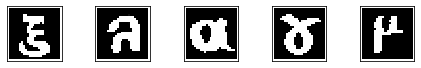

<ipython-input-4-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 3.7154, Accuracy: 4/96 (4%)

Train epoch: 1 [0/240 (0%)]	Loss: 3.939344
Train epoch: 1 [50/240 (21%)]	Loss: 28.289959
Train epoch: 1 [100/240 (42%)]	Loss: 5.426642
Train epoch: 1 [150/240 (62%)]	Loss: 25.184383
Train epoch: 1 [200/240 (83%)]	Loss: 82.897629
Test set: Avg. loss: 47.1912, Accuracy: 34/96 (35%)

Train epoch: 2 [0/240 (0%)]	Loss: 15.123968
Train epoch: 2 [50/240 (21%)]	Loss: 32.361046
Train epoch: 2 [100/240 (42%)]	Loss: 82.715759
Train epoch: 2 [150/240 (62%)]	Loss: 23.898853
Train epoch: 2 [200/240 (83%)]	Loss: 52.217285
Test set: Avg. loss: 25.2343, Accuracy: 48/96 (50%)

Train epoch: 3 [0/240 (0%)]	Loss: 22.559677
Train epoch: 3 [50/240 (21%)]	Loss: 39.784790
Train epoch: 3 [100/240 (42%)]	Loss: 34.850300
Train epoch: 3 [150/240 (62%)]	Loss: 77.235237
Train epoch: 3 [200/240 (83%)]	Loss: 89.772049
Test set: Avg. loss: 20.9992, Accuracy: 49/96 (51%)

Train epoch: 4 [0/240 (0%)]	Loss: 31.204639
Train epoch: 4 [50/240 (21%)]	Loss: 4.403615
Train epoch

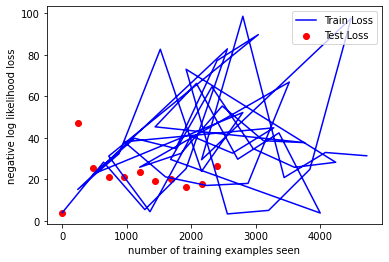

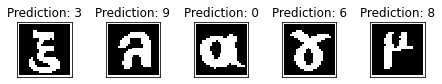

In [8]:
main()